# Image Colorization with Deep Neural Network


# Entire Simplified Process can be summarized as -->

1. Convert all the training images of RGB to Lab Color Space
2. Use the `L channel` as input of the network and train the network to predict the `a and b channels`.
3. Combine the input `L channel` and the predicted `a and b channels`.
4. Convert the Lab image back to RGB.


For more details on the image colorization algorithm and deep learning model, be sure to refer to the official publication of Zhang et al `provided`.

In [ ]:
# getting the necessary models from drive or provided

!gdown --id 1qg47Ayr5LuqqTGUaCzNCNa97eU2oQlhT
!gdown --id 1NLIO0oZhDXzQ7L2D8TjsrmPMh4ohfuUu
!gdown --id 1ulmIA05Oxbufed4awVFzdG-6TZl0cYg2

Downloading...
From: https://drive.google.com/uc?id=1qg47Ayr5LuqqTGUaCzNCNa97eU2oQlhT
To: /content/colorization_deploy_v2.prototxt
100% 9.95k/9.95k [00:00<00:00, 17.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1NLIO0oZhDXzQ7L2D8TjsrmPMh4ohfuUu
To: /content/colorization_release_v2.caffemodel
129MB [00:03, 40.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ulmIA05Oxbufed4awVFzdG-6TZl0cYg2
To: /content/pts_in_hull.npy
100% 5.09k/5.09k [00:00<00:00, 14.7MB/s]


In [ ]:
# making necessary imports

import numpy as np
import cv2 as cv
import os.path
import argparse

In [ ]:
# downloading sample black-white image (if not provided)
!wget https://blinq.art/blog/wp-content/uploads/2018/04/blinq-art-black-white-default.jpg

--2020-11-19 11:21:08--  https://blinq.art/blog/wp-content/uploads/2018/04/blinq-art-black-white-default.jpg
Resolving blinq.art (blinq.art)... 40.126.224.45
Connecting to blinq.art (blinq.art)|40.126.224.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91441 (89K) [image/jpeg]
Saving to: ‘blinq-art-black-white-default.jpg’

blinq-art-black-whi 100%[===================>]  89.30K   221KB/s    in 0.4s    

2020-11-19 11:21:09 (221 KB/s) - ‘blinq-art-black-white-default.jpg’ saved [91441/91441]



In [ ]:
!wget https://helpx.adobe.com/content/dam/help/en/photoshop/using/convert-color-image-black-white/jcr_content/main-pars/before_and_after/image-after/Landscape-BW.jpg

--2020-11-19 12:04:12--  https://helpx.adobe.com/content/dam/help/en/photoshop/using/convert-color-image-black-white/jcr_content/main-pars/before_and_after/image-after/Landscape-BW.jpg
Resolving helpx.adobe.com (helpx.adobe.com)... 23.33.181.6, 2600:1408:9000:28a::1efd, 2600:1408:9000:28f::1efd
Connecting to helpx.adobe.com (helpx.adobe.com)|23.33.181.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 695215 (679K) [image/jpeg]
Saving to: ‘Landscape-BW.jpg’

Landscape-BW.jpg    100%[===================>] 678.92K  --.-KB/s    in 0.01s   

2020-11-19 12:04:13 (60.5 MB/s) - ‘Landscape-BW.jpg’ saved [695215/695215]



In [ ]:
# construct the argument parser and parse the arguments
# so we just need to add the path of the file only at one place (if need to)

image = '/content/Landscape-BW.jpg'                        # path of the input image
prot       = '/content/colorization_deploy_v2.prototxt'    # path of the Caffe prototxt file
mod        = '/content/colorization_release_v2.caffemodel' # path of the Caffe pre-trained model
cluster_pts = '/content/pts_in_hull.npy'                   # path of the cluster center points

# if want to use command line
'''
ap = argparse.ArgumentParser() # initiate the argparse object
ap.add_argument("-i", "--image", type=str, required=True, # --i is (shorthand) and --image (longhand) names of the arguments
                help='path of the input image')
ap.add_argument("-p", "--prototxt file", type=str, required=True,
                help='path of the Caffe prototxt file')
ap.add_argument("-m", "--model", type=str, required=True,
                help='path of the Caffe pre-trained model')
ap.add_argument("-c", "--points", type=str, required=True,
                help='path of the cluster center points')
args = vars(ap.parse_args())
'''

'\nap = argparse.ArgumentParser() # initiate the argparse object\nap.add_argument("-i", "--image", type=str, required=True, # --i is (shorthand) and --image (longhand) names of the arguments\n                help=\'path of the input image\')\nap.add_argument("-p", "--prototxt file", type=str, required=True,\n                help=\'path of the Caffe prototxt file\')\nap.add_argument("-m", "--model", type=str, required=True,\n                help=\'path of the Caffe pre-trained model\')\nap.add_argument("-c", "--points", type=str, required=True,\n                help=\'path of the cluster center points\')\nargs = vars(ap.parse_args())\n'

In [ ]:
frame = cv.imread(image) # getting the input (black-white image)

numpy_file = np.load(cluster_pts) # loading numpy clusters points (downloaded above)

Caffe_net = cv.dnn.readNetFromCaffe(prot, mod) # loading the caffe model (downloaded above)

In [ ]:
# the following code will do -->
# 1. Load centers for ab channel quantization used for rebalancing.
# 2. Treat each of the points as 1×1 convolutions and add them to the model.

numpy_file = numpy_file.transpose().reshape(2, 313, 1, 1) # transposing the cluster points for 1x1 convolution
Caffe_net.getLayer(Caffe_net.getLayerId('class8_ab')).blobs = [numpy_file.astype(np.float32)] # loading centers for ab channel
Caffe_net.getLayer(Caffe_net.getLayerId('conv8_313_rh')).blobs = [np.full([1, 313], 2.606, np.float32)] # treating each of the points as 1x1 convolution and adding to the model

In [ ]:
# reshaping the image as the model has been trained on ImageNet dataset of 224x224 image size
input_width = 224 
input_height = 224

rgb_img = (frame[:,:,[2, 1, 0]] * 1.0 / 255).astype(np.float32) # getting the rgb image and scaling (converting values between 0 and 1) it
lab_img = cv.cvtColor(rgb_img, cv.COLOR_RGB2Lab) # converting image to Lab Color Space
l_channel = lab_img[:,:,0] # getting the L channel to train on the network

l_channel_resize = cv.resize(l_channel, (input_width, input_height))  # resizing the l channel for the network
l_channel_resize -= 50 # mean centering the L channel (Mean Centering is subtracting mean of all the instances(images in case) from every instance so as to make the mean value of every instance zero) make the computation easy

In [ ]:
Caffe_net.setInput(cv.dnn.blobFromImage(l_channel_resize)) # passing the L channel to the network to predict ab channels
ab_channel = Caffe_net.forward()[0,:,:,:].transpose((1,2,0)) # predicted ab channel

(original_height,original_width) = rgb_img.shape[:2]                        # original shape of the input image
ab_channel_us = cv.resize(ab_channel, (original_width, original_height))    # resizing the ab channel to the original input image
lab_output = np.concatenate((l_channel[:,:,np.newaxis],ab_channel_us),axis=2)   # Grabbing the L channel from the orginal 
bgr_output = np.clip(cv.cvtColor(lab_output, cv.COLOR_Lab2BGR), 0, 1)           # clipping the pixel instance lies between 0 and 1, and converting the lab color space to RGB

cv.imwrite("./result.png", (bgr_output*255).astype(np.uint8)) # bringing the pixel instances back into the range of [0, 255] and saving the image as "file_name.png"


True

<Figure size 1080x1080 with 0 Axes>

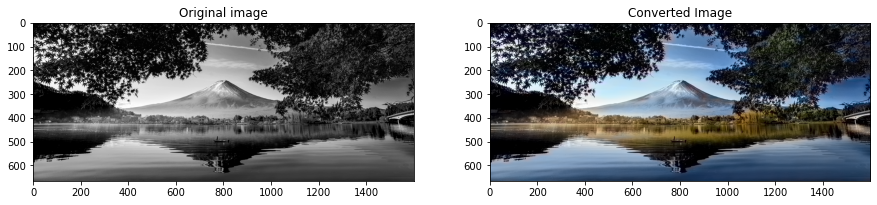

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
org_img = mpimg.imread(image) # original black-white image
con_img = mpimg.imread('/content/result.png') # converted colored-image

# comparing the result with the original
plt.figure(figsize=(15,15), facecolor='white') # making the background white
fig, (ax1, ax2) = plt.subplots(1, 2) # creating two image side by side
fig.set_facecolor('white') # background of image
fig.set_figwidth(15) # height of the figure
fig.set_figheight(15) # weight of the figure
ax1.set_title('Original image') # title
ax1.imshow(org_img) # plotting the  image
ax2.set_title('Converted Image') 
ax2.imshow(con_img)
#fig.savefig('tapesh.png') # saving the figure